In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import scipy.stats as sps

import time
import pickle

import MOODS.parsers
import MOODS.tools
import MOODS.scan

from tqdm import tqdm

import sys
sys.path.insert(-1, '/projectnb/encore/sofyaga/promoters_position_dependency/' )
sys.path.insert(-1, '/projectnb/evolution/sofyaga/asfrompromoters/supporting_data/tissue_calculations/' )
import rmats_parser as rmatsp


/usr3/graduate/sofyaga/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


transcription factors from Maritere 

SP2
KLF1
KLF14
PATZ1
KLF15
KLF5
KLF12
KLF7
CTCFL
KLF10
SP4
ZNF148
ZNF93
SP1
ZBTB14


From the Puffin 

TATA
YY1

NFY 
ETS 
SP 
ZNF143 
NRF1 
CREB


TATA and YY1 have strong activating effects on transcriptional initiation signals, preferentially on one strand, whereas bidirectional motifs such as NFY, ETS, SP, ZNF143, NRF1, and CREB

In [6]:
with open('gene_to_pwm_dict.pickle', 'rb') as handle:
    gene_to_pwm = pickle.load(handle)

with open('pwm_matrices_for_moods.pickle', 'rb') as handle:
    pwm_matrices = pickle.load(handle)

with open('mood_thresholds_001.pickle', 'rb') as handle:
    threshold_dict_001 =  pickle.load(handle)

with open('mood_thresholds_0001.pickle', 'rb') as handle:
    threshold_dict_0001 =  pickle.load(handle)


with open('pwm_matrice_choice_per_gene.pickle', 'rb') as handle:
    gene_to_unique_pwm = pickle.load(handle)


In [2]:
complement = {'A':'T', 'T':'A', 'C':'G', 'G':'C', 'N':'N'}
def reverse_complememntary(sequence):
    complementary = [complement[nuc.upper()] for nuc in sequence]
    return ''.join(complementary[::-1])



def get_region_sequence(chromosome, region_start, region_end):
    
    cmd = ['samtools', 'faidx', '/projectnb/evolution/sofyaga/raw_data/hg38.fa',
           f'{chromosome}:{region_start}-{region_end}']

    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()


    seq = ''
    for elem in stdout.decode().split('\n'):
#         print(elem)
        if elem.startswith('>'):
            continue
        else:
            seq += elem
    return seq


In [3]:
# # cheked on a few examples in genome browser, and seems to work!
def get_a_motif_scan(genome_sequence, pwm_list, pwm_name_list, pwm_threshold_list):

    bg = MOODS.tools.flat_bg(4)

    scan_df = list()

    sequence_length = len(genome_sequence)
    result = MOODS.scan.scan_dna(genome_sequence, pwm_list, bg, pwm_threshold_list, 7)
    result_c = MOODS.scan.scan_dna(reverse_complememntary(genome_sequence), pwm_list, bg, pwm_threshold_list, 7)
    
    to_concatenate = list()
    for idx, pwm_name in enumerate(pwm_name_list):
        pwm_length = len(pwm_list[idx][0])
        site_data_f = [[match.pos, match.score] for match in result[idx]]
        site_data_f = pd.DataFrame(site_data_f, columns = ['start', 'score'])
        site_data_f['end'] = site_data_f['start'] + pwm_length
        site_data_f['ori'] = '+'
        site_data_f['pwm']= pwm_name

        site_data_c = [[match.pos, match.score] for match in result_c[idx]]
        site_data_c = pd.DataFrame(site_data_c, columns = ['start', 'score'])
        site_data_c['end'] = site_data_c['start']  + pwm_length
        site_data_c['start'], site_data_c['end'] = sequence_length - site_data_c['end'], sequence_length - site_data_c['start']
        site_data_c['ori'] = '-'
        site_data_c['pwm']= pwm_name
    
        
        to_concatenate.append(site_data_f)
        to_concatenate.append(site_data_c) 
        
    scan_df = pd.concat(to_concatenate).sort_values(by='start').reset_index(drop = True)
    

    return scan_df

In [4]:
def get_snp_sequences(snp_id, PAD=51):

    chromosome, pos, wt, mut, _ = snp_id.split('_')
    pos = int(pos)

    if len(mut) != 1 or len(wt) != 1:
        return '', ''

    PAD = 51
    region_start = pos - PAD
    region_end = pos + PAD

    wt_sequence = get_region_sequence(chromosome, region_start, region_end)
    mut_sequence = wt_sequence[:PAD] + mut + wt_sequence[PAD + 1:]
    assert wt_sequence[PAD].upper() == wt
    assert mut_sequence[PAD].upper() == mut

    return wt_sequence, mut_sequence



def get_tf_intersections_with_snps(list_of_snps):
    PAD = 51
    concat_wt = ''
    concat_mut = ''

    snp_sequence_added = list()

    for snp_id in list_of_snps:
        wt_sequence, mut_sequence = get_snp_sequences(snp_id, PAD=51)
        if len(wt_sequence) == 0:
            continue
        concat_wt += wt_sequence
        concat_mut += mut_sequence
        snp_sequence_added.append(snp_id)


    wt_scan_df = get_a_motif_scan(concat_wt, pwm_list, pwm_gene_names, pwm_threshold_list)
    mut_scan_df = get_a_motif_scan(concat_mut, pwm_list, pwm_gene_names, pwm_threshold_list)


    tf_result_to_concat = list()
    
    for idx, snp_id in enumerate(snp_sequence_added):

        temp = pd.DataFrame(wt_scan_df)
        temp = temp[temp['end'] > PAD + (PAD*2 + 1)*idx]
        temp = temp[temp['start'] <=  PAD + (PAD*2 + 1)*idx]
        temp['snp_id'] = snp_id
        temp['start'] -= (PAD*2 + 1)*idx
        temp['end'] -= (PAD*2 + 1)*idx
        wt_temp = temp

        temp = mut_scan_df
        temp = temp[temp['end'] > PAD + (PAD*2 + 1)*idx]
        temp = temp[temp['start'] <=  PAD + (PAD*2 + 1)*idx]
        temp['snp_id'] = snp_id
        temp['start'] -= (PAD*2 + 1)*idx
        temp['end'] -= (PAD*2 + 1)*idx
        mut_temp = temp

        tf_result_to_concat.append(wt_temp.merge(mut_temp, how = 'outer', 
                                    on = ['snp_id', 'pwm', 'start', 'end', 'ori'], 
                                    suffixes=['_wt', '_mut']))
        

    return pd.concat(tf_result_to_concat).reset_index(drop = True)

In [7]:

pwm_gene_names = [gene for gene in gene_to_unique_pwm.keys()]
pwm_list = [pwm_matrices[gene_to_unique_pwm[gene]] for gene in pwm_gene_names]
pwm_threshold_list = [threshold_dict_0001[gene_to_unique_pwm[gene]] for gene in pwm_gene_names]



In [8]:
intersection = pd.read_csv('01_12_intersection_encode.tsv', sep = '\t')
unique_snps = intersection['snpID'].unique()
len(unique_snps)

# tt = time.time()
# list_of_snps = unique_snps
# tf_intersection_df = get_tf_intersections_with_snps(list_of_snps)
# tf_intersection_df.to_csv('230_snp_tf_influence.tsv', sep = '\t', index=  False)
# print(time.time() - tt)

tf_intersection_df = pd.read_csv('230_snp_tf_influence.tsv', sep = '\t')


# CONTROL

In [9]:
exon_snp_pairs_01 = pd.read_csv('encode_unique_exon_snp_pairs_01.tsv', sep = '\t')
exon_snp_pairs_12 = pd.read_csv('encode_unique_exon_snp_pairs_12.tsv', sep = '\t')

collapsed_01 = pd.read_csv('encode_snp_exon_collapsed_01.tsv', sep = '\t')
collapsed_12 = pd.read_csv('encode_snp_exon_collapsed_12.tsv', sep = '\t')


with open('./tissue_calculations/genes_with_encodepromoter_snps.pickle', 'rb') as handle:
    genes_with_exons = pickle.load(handle)


genes_to_abundant_snps = dict()

for gene in tqdm(genes_with_exons):
    sample_columns = genes_with_exons[gene].sample_columns
    sums = (genes_with_exons[gene].snp_data[sample_columns] > 0).sum(axis = 1)
    genes_with_exons[gene].snp_data['snp_count'] = sums
    temp = genes_with_exons[gene].snp_data
    temp = temp[temp['snp_count'] > 10]
    if len(temp) == 0:
        continue
    genes_to_abundant_snps[gene] = temp['ID'].values


100%|██████████| 19817/19817 [00:42<00:00, 470.62it/s]


In [10]:
snps_01 = collapsed_01['snpID'].unique()
snps_12 = collapsed_12['snpID'].unique()

In [11]:
# tf_for_01_snps = get_tf_intersections_with_snps(snps_01)
# tf_for_01_snps.to_csv('tfs_for_01_snps.csv', sep = '\t', index=  False)
# tf_for_12_snps = get_tf_intersections_with_snps(snps_12)
# tf_for_12_snps.to_csv('tfs_for_12_snps.csv', sep = '\t', index=  False)

tf_for_01_snps = pd.read_csv('tfs_for_01_snps.csv', sep = '\t')
tf_for_12_snps = pd.read_csv('tfs_for_12_snps.csv', sep = '\t')

In [12]:
random_snps_one_per_gene = list()

np.random.seed(183)
for gene in np.random.choice(list(genes_to_abundant_snps.keys()), size = 13050, replace=False):
    snp = np.random.choice(genes_to_abundant_snps[gene], size = 1)
    random_snps_one_per_gene.append(snp[0])

 
# tf_with_random_promoter_snps = get_tf_intersections_with_snps(random_snps_one_per_gene)
# tf_with_random_promoter_snps.to_csv('tfs_for_random_per_gene_snps.csv', sep = '\t', index=  False)

tf_with_random_promoter_snps = pd.read_csv('tfs_for_random_per_gene_snps.csv', sep = '\t')

In [17]:
tf_with_random_promoter_snps

,start,score_wt,end,ori,pwm,snp_id,score_mut
0,42,-13.821591,71,+,ZBTB16,chr15_41332851_C_A_b38,-12.871582
1,31,NaN,60,+,ZBTB16,chr15_41332851_C_A_b38,-16.725826
2,44,NaN,54,-,ZBTB32,chr15_41332851_C_A_b38,-4.103307
3,28,-35.409805,57,+,ZNF487,chr6_24799050_C_T_b38,-34.157041
4,29,-19.212692,59,-,ZNF235,chr6_24799050_C_T_b38,-17.951559
...,...,...,...,...,...,...,...
214202,50,-19.149161,70,+,HCFC1,chr21_41507797_G_A_b38,-19.022868
214203,50,-9.514142,64,+,SMARCC2,chr21_41507797_G_A_b38,-9.423214
214204,51,-1.370402,64,+,ASCL1,chr21_41507797_G_A_b38,-1.573412
214205,51,-4.139135,64,+,MYOD1,chr21_41507797_G_A_b38,-4.262616


## Analyze with control! 

In [15]:
tf_with_random_promoter_snps

,start,score_wt,end,ori,pwm,snp_id,score_mut
0,42,-13.821591,71,+,ZBTB16,chr15_41332851_C_A_b38,-12.871582
1,31,NaN,60,+,ZBTB16,chr15_41332851_C_A_b38,-16.725826
2,44,NaN,54,-,ZBTB32,chr15_41332851_C_A_b38,-4.103307
3,28,-35.409805,57,+,ZNF487,chr6_24799050_C_T_b38,-34.157041
4,29,-19.212692,59,-,ZNF235,chr6_24799050_C_T_b38,-17.951559
...,...,...,...,...,...,...,...
161875,46,-4.083276,59,-,FOXI1,chr6_31836833_G_A_b38,-4.712704
161876,49,-2.974555,61,+,FUBP1,chr6_31836833_G_A_b38,NaN
161877,36,NaN,62,+,HMGA2,chr6_31836833_G_A_b38,-11.857790
161878,36,NaN,62,+,HMGA1,chr6_31836833_G_A_b38,-11.857790


In [18]:
# lets find the factors that change in some consistent way! 


snps_increase_inclusion = list(collapsed_01[collapsed_01['diff_0_1'] < 0]['snpID'].values)
snps_increase_exclusion = list(collapsed_01[collapsed_01['diff_0_1'] > 0]['snpID'].values)


tfs = sorted(tf_for_01_snps.pwm.unique())


in_ex_factor_data = list()

for TF in tfs:

    temp = tf_for_01_snps
    temp = temp[temp['pwm'] == TF]

    # for snps increasing inclusion:
    snp_temp = temp[temp['snp_id'].isin(snps_increase_inclusion)]
    wt_scores = np.nan_to_num(snp_temp['score_wt'].values, nan=-100)
    mut_scores = np.nan_to_num(snp_temp['score_mut'].values, nan=-100)
    inc_tf_increase = sum(wt_scores < mut_scores)
    inc_tf_decrease = sum(wt_scores > mut_scores)

    
    # for snps increasing exclusion: 
    snp_temp = temp[temp['snp_id'].isin(snps_increase_exclusion)]
    wt_scores = np.nan_to_num(snp_temp['score_wt'].values, nan=-100)
    mut_scores = np.nan_to_num(snp_temp['score_mut'].values, nan=-100)
    exc_tf_increase = sum(wt_scores < mut_scores)
    exc_tf_decrease = sum(wt_scores > mut_scores)

    # for random promoter_snps 
    snp_temp = tf_with_random_promoter_snps
    wt_scores = np.nan_to_num(snp_temp['score_wt'].values, nan=-100)
    mut_scores = np.nan_to_num(snp_temp['score_mut'].values, nan=-100)
    con_tf_increase = sum(wt_scores < mut_scores)
    con_tf_decrease = sum(wt_scores > mut_scores)

    in_ex_factor_data.append([TF, inc_tf_increase, inc_tf_decrease, exc_tf_increase, exc_tf_decrease, 
                            len(snps_increase_inclusion),len(snps_increase_exclusion), 
                            sps.fisher_exact([[inc_tf_increase, inc_tf_decrease], [exc_tf_increase, exc_tf_decrease]])[1], 
                            con_tf_increase, con_tf_decrease, 
                            sps.fisher_exact([[inc_tf_increase, inc_tf_decrease], [con_tf_increase, con_tf_decrease]])[1], 
                            sps.fisher_exact([[exc_tf_increase, exc_tf_decrease], [con_tf_increase, con_tf_decrease]])[1]])


In [19]:
in_ex_factor_df = pd.DataFrame(in_ex_factor_data, columns = ['pwm', 'inc_tf_increase', 'inc_tf_decrease', 'exc_tf_increase', 'exc_tf_decrease', 
                                'n_snp_inc_in', 'n_snp_inc_ex', 'fisher_p_inc_exc', 'con_tf_increase', 'con_tf_increase', 
                                'fisher_p_inc_con', 'fisher_p_exc_con',])
in_ex_factor_df          

,pwm,inc_tf_increase,inc_tf_decrease,exc_tf_increase,exc_tf_decrease,n_snp_inc_in,n_snp_inc_ex,fisher_p_inc_exc,con_tf_increase,con_tf_increase,fisher_p_inc_con,fisher_p_exc_con
0,ADNP,19,19,14,16,13097,13011,0.811559,92292,120597,0.417795,0.716713
1,AFF4,51,90,46,83,13097,13011,1.000000,92292,120597,0.089437,0.090967
2,AHR,12,11,11,9,13097,13011,1.000000,92292,120597,0.407667,0.367842
3,AIRE,8,3,9,8,13097,13011,0.434877,92292,120597,0.066684,0.468983
4,ALX1,0,5,1,1,13097,13011,0.285714,92292,120597,0.073646,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1255,puffin_SP,95,104,99,96,13097,13011,0.614407,92292,120597,0.223990,0.042698
1256,puffin_TATA,13,9,12,10,13097,13011,1.000000,92292,120597,0.195581,0.292559
1257,puffin_U1_snRNP,13,13,16,10,13097,13011,0.577086,92292,120597,0.554905,0.074521
1258,puffin_YY1,5,6,6,7,13097,13011,1.000000,92292,120597,1.000000,1.000000


In [20]:
in_ex_factor_df[in_ex_factor_df['fisher_p_inc_exc'] < 0.1]

,pwm,inc_tf_increase,inc_tf_decrease,exc_tf_increase,exc_tf_decrease,n_snp_inc_in,n_snp_inc_ex,fisher_p_inc_exc,con_tf_increase,con_tf_increase,fisher_p_inc_con,fisher_p_exc_con
35,BARX2,6,3,0,5,13097,13011,0.030969,92292,120597,0.188894,7.364647e-02
86,CUX2,4,0,0,2,13097,13011,0.066667,92292,120597,0.035324,5.088375e-01
88,DACH1,9,6,15,1,13097,13011,0.037251,92292,120597,0.204342,3.412303e-05
142,EP300,17,31,30,21,13097,13011,0.026818,92292,120597,0.309009,3.312986e-02
160,ETV7,13,11,6,20,13097,13011,0.040437,92292,120597,0.308211,4.638395e-02
170,FLI1,4,9,8,3,13097,13011,0.099533,92292,120597,0.414586,6.668442e-02
339,IKZF1,17,4,22,16,13097,13011,0.090891,92292,120597,0.000608,7.383952e-02
341,IKZF3,290,324,261,394,13097,13011,0.009120,92292,120597,0.055272,7.552431e-02
374,KLF13,37,55,31,81,13097,13011,0.073272,92292,120597,0.599313,7.799373e-04
375,KLF14,43,61,33,80,13097,13011,0.065703,92292,120597,0.693700,2.292970e-03


In [46]:
sorted(Maritere_TFs)

['CTCFL',
 'KLF1',
 'KLF10',
 'KLF12',
 'KLF14',
 'KLF15',
 'KLF5',
 'KLF7',
 'PATZ1',
 'SP1',
 'SP2',
 'SP4',
 'ZBTB14',
 'ZNF148',
 'ZNF93']

In [42]:
Maritere

NameError: name 'Maritere_TFs' is not defined

In [26]:
in_ex_factor_df['inc_frac_tf_up'] = in_ex_factor_df['inc_tf_increase']/(in_ex_factor_df['inc_tf_increase'] + in_ex_factor_df['inc_tf_decrease'])
in_ex_factor_df['exc_frac_tf_up'] = in_ex_factor_df['exc_tf_increase']/(in_ex_factor_df['exc_tf_increase'] + in_ex_factor_df['exc_tf_decrease'])

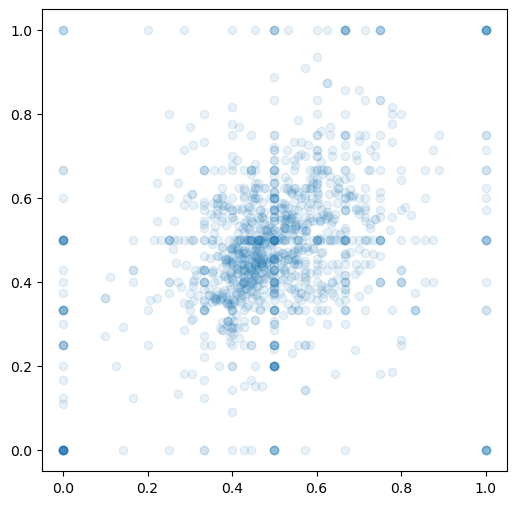

In [28]:
x, y = in_ex_factor_df['inc_frac_tf_up'], in_ex_factor_df['exc_frac_tf_up']


plt.figure(figsize = (6, 6))
plt.scatter(x, y, alpha = 0.1)


In [56]:
interesting = tf_for_01_snps[tf_for_01_snps['pwm'] == 'CUX2'].snp_id

In [57]:
collapsed_01[collapsed_01['snpID'].isin(list(interesting))]

# ENSG00000151725.11 	blood_ebv-transformed-lymphocytes 	16 	184734333 	

,exon_start,exon_end,upes,upee,does,doee,snpID,diff_0_1,pval_0_1,len_0,len_1,inc_0,inc_1,inc_2,gene,tissue,min_group_size,snp_pos,transcription_d
9451,102727674,102727791,102726986,102727157,102728430,102728511,chr10_102743827_C_T_b38,-0.118513,0.005322,67,106,0.281;0.207;0.000;0.072;0.128;0.135;0.253;0.42...,0.230;0.281;0.439;0.260;0.457;0.207;0.811;0.18...,0.190;0.394;0.369;0.717;0.246;0.094;0.439;0.06...,ENSG00000156398.12,spleen,67,102743827,16153
16931,152145486,152145555,152143622,152143765,152148044,152148378,chr6_152472493_C_T_b38,-0.168483,0.002816,300,24,0.400;0.444;0.502;0.510;0.493;0.974;0.966;0.90...,0.522;0.315;0.989;0.854;0.978;0.818;0.368;0.75...,NaN,ENSG00000131018.22,stomach,24,152472493,-326938
23392,202942739,202942967,202917876,202918043,202952558,202952620,chr2_202911810_T_G_b38,0.108149,0.003954,383,11,1.000;1.000;0.899;1.000;1.000;0.941;1.000;0.72...,1.000;0.776;0.842;0.740;0.409;0.748;0.916;0.92...,NaN,ENSG00000138380.17,breast_mammary-tissue,11,202911810,-30929


In [43]:
def classity_tf_changes(row):
    if np.isnan(row['score_mut']):
        return 'delete'
    elif np.isnan(row['score_wt']):
        return 'appear'
    elif row['score_wt'] < row['score_mut']:
        return 'increase'
    elif row['score_wt'] > row['score_mut']:
        return 'decrease'
    elif row['score_wt'] == row['score_mut']:
        return 'non-changed'
    return 'na'


Maritere_TFs = ['SP2', 'KLF1', 'KLF14', 'PATZ1', 'KLF15', 'KLF5', 'KLF12', 
'KLF7', 'CTCFL', 'KLF10', 'SP4', 'ZNF148', 'ZNF93', 'SP1', 'ZBTB14']
puffin_tfs = ['puffin_Long_Inr', 'puffin_NFY', 'puffin_NRF1', 
'puffin_SP', 'puffin_TATA', 'puffin_U1_snRNP', 'puffin_ZNF143']


# tf_intersection_df['class'] = tf_intersection_df.apply(lambda row: classity_tf_changes(row), axis = 1)
# tf_with_random_promoter_snps['class'] = tf_with_random_promoter_snps.apply(lambda row: classity_tf_changes(row), axis = 1) 

In [12]:
tf_with_random_promoter_snps['class'].value_counts()/16750

class
delete         0.358388
appear         0.262806
decrease       0.216179
increase       0.157075
non-changed    0.005552
Name: count, dtype: float64

In [13]:
tf_intersection_df['class'].value_counts()/3503

class
delete         0.354268
appear         0.298601
decrease       0.179275
increase       0.162718
non-changed    0.005138
Name: count, dtype: float64

In [14]:
len(unique_snps)

271

(-0.5, 15.0)

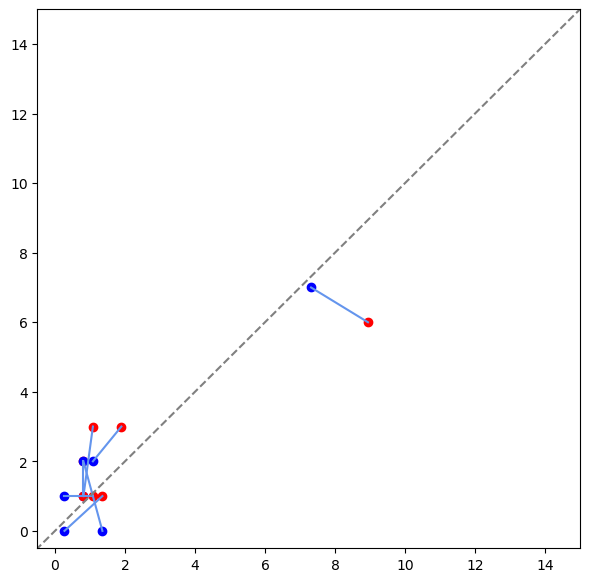

In [21]:

plt.figure(figsize=(7, 7))

for tf in puffin_tfs:
    pwm_id = gene_to_unique_pwm[tf]
    threshold_dict_001[pwm_id]
    replace_nans_with = threshold_dict_001[pwm_id] - 1

    temp = tf_with_random_promoter_snps
    temp = temp[temp['pwm'] == tf]
    wt_scores = temp['score_wt'].values
    mut_scores = temp['score_mut'].values
    wt_scores[np.isnan(wt_scores)] = replace_nans_with
    mut_scores[np.isnan(mut_scores)] = replace_nans_with
    increased_num = sum(wt_scores < mut_scores)
    decreased_num = sum(wt_scores > mut_scores)

    increase_exp = increased_num/1000*271
    decrease_exp = decreased_num/1000*271


    temp = tf_intersection_df
    temp = temp[temp['pwm'] == tf]
    wt_scores = temp['score_wt'].values
    mut_scores = temp['score_mut'].values
    wt_scores[np.isnan(wt_scores)] = replace_nans_with
    mut_scores[np.isnan(mut_scores)] = replace_nans_with
    increased_num = sum(wt_scores < mut_scores)
    decreased_num = sum(wt_scores > mut_scores)
    
    plt.scatter(increase_exp, increased_num, color= 'red')
    plt.scatter(decrease_exp, decreased_num, color= 'blue')
    plt.plot([increase_exp, decrease_exp], [increased_num, decreased_num], color = 'cornflowerblue')




plt.plot([-1, 100], [-1, 100], color = 'grey', linestyle = '--')
plt.xlim(-0.5, 15)
plt.ylim(-0.5, 15)